# Mean MCEP

### Loading all the required libraries. 

In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import sys
sys.path.insert(0, "..")

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip3 install pysptk

     |████████████████████████████████| 410 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.1.20-cp37-cp37m-linux_x86_64.whl size=929919 sha256=d96d6f42527e5a4dd3aa15a567e06915bb6ea6388642c7e790e5ee2cdf3d29a8
  Stored in directory: /root/.cache/pip/wheels/dd/37/3f/7583b00bf73e73650aad5d268ee46b95dbd6dffbd237e1bf58
Successfully built pysptk


In [4]:
!pip3 install pyworld

     |████████████████████████████████| 212 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyworld: filename=pyworld-0.3.0-cp37-cp37m-linux_x86_64.whl size=609513 sha256=155d88d15b7ed324ec1feb5d7013f565065d4825d4c7d7c452e57a4b0fa3b631
  Stored in directory: /root/.cache/pip/wheels/e7/7c/11/c775fffa0e1e7b05a6604b4323408a77f80fb4ab304d96b5c6
Successfully built pyworld


In [5]:
import torch
from scipy.io import wavfile
import pysptk
from pysptk.synthesis import Synthesizer, MLSADF
import pyworld
from os.path import join, basename
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import glob
import os
import numpy as np
from os.path import join, basename
import collections

# Loading Data 
* Upload your data in your google drive 
* Run the cell below , and your drive will be accessible from this notebook. This will ask for your permission.
* After granting the permission , you can access any folder or file in your drive from this notebook environment.



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def getpaths():  
  """
  This function takes input from the user , i.e. , the number of datasets and the path of the datasets
  
  """
  print("Enter No. of Datasets :")
  n=int(input())
  paths=[]
  for i in range(n):
    if i ==0:
      paths.append(input("Enter Original path : "))
    else:
      paths.append(input(f"Enter path{i+1} : "))
  return paths

### Enter the number of datasets and the paths :
* Enter a numrical value , like 2/4 with respect to the number of datasets you want to visualize.
* Enter the path of the original data first.
* Then you can put the path of the other datasets. 

### Note : The datasets should contain same number of wav files with the same name of each wav file.

In [9]:
paths=getpaths()

Enter No. of Datasets :
4
Enter Original path : /content/drive/MyDrive/Male-to-Male-Voice/SM1
Enter path2 : /content/drive/MyDrive/Male-to-Male-Voice/converted_SM2_Speech_in_SM1_Voice
Enter path3 : /content/drive/MyDrive/Male-to-Male-Voice/SM2
Enter path4 : /content/drive/MyDrive/Male-to-Male-Voice/SM1_SM2_spcycle


### Funtion to compute the static feature - 
* Takes wav file path as input.
* Returns the Mel-Cepstrum value as output.

In [10]:
def compute_static_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=5.0)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=24, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    # print(shape(mc))
    mc=mc
    # print(shape(mc))
    return mc

### Function to calculate RMSE value 

In [11]:
def calc_rmse(x,y):
    min=np.sqrt(((x - y) ** 2).mean())
    return min

### Function to calculate MCEP values:
* Takes the paths as input.
* Takes user input for Labels  for the plot, with respect to each dataset.
* Calculates the MCEP values of all the datasets.

In [12]:
from numpy.core.fromnumeric import shape
def get_mc(paths):
    print("Enter the Labels : ")
    labels=[]
    n=len(paths)
    for i in range(n):
      if i ==0:
        labels.append(input("Enter label for Original path : "))
      else:
        labels.append(input(f"Enter label for path_{i} : "))


    mcep_dict = collections.defaultdict(list)
    file_paths={}
    for i in range(n):
      path=glob.glob(paths[i]+'/*')
      file_paths[f'path_{i+1}'] =sorted(path)
      for wav in file_paths[f'path_{i+1}']:
        mc=compute_static_features(wav)
        mcep_dict[f'path_{i+1}'].append(mc)

    #(gv_dict[0][1]))
    mini=[]
    x=1
    for i in range(len(mcep_dict['path_1'])):
      j=1
      min_dif=0
      while (j+1)<=n:
        if shape(mcep_dict['path_1'][i])==shape(mcep_dict[f'path_{j+1}'][i]):
          min_dif+=(calc_rmse(mcep_dict['path_1'][i],mcep_dict[f'path_{j+1}'][i]))
        #print(min_dif,j)
        else:
          x=0
        j+=1
      #print(min_dif)
      mini.append(min_dif)
    for i in range(len(mini)):
      if mini[i]==0:
        mini[i]=1
    ind=mini.index(min(mini))
    return mcep_dict,labels,ind

In [13]:
lists,labels,ind=get_mc(paths)

Enter the Labels : 
Enter label for Original path : Original
Enter label for path_1 : Synthesized
Enter label for path_2 : CycleGAN
Enter label for path_3 : StarGAN


### Function to visualize Modulation Spectrum:
* Takes the MCEP values , labels , index for best value.
* Compare the values and shows the best plot from the dataset for the means of the MCEP values of each dimension.

In [19]:
def vis(lists,labels,ind,):  
  plt.rcParams.update({'font.size': 20})
  fig, ax = plt.subplots(figsize=(24,8))
  print("Enter the Markers for each label [few common markers - x , + , o , * , > , < , D , H , X , v , ^ ]:")
  marker=[]
  n=len(labels)
  for i in range(n):
    if i ==0:
      marker.append(input("Enter marker for Original path : "))
    else:
      marker.append(input(f"Enter marker for path_{i+1} : "))

  j=0
  for i in lists.keys():
      arr=np.asarray(lists[i][ind]).T

      #plt.plot(gv_dict[i][1], marker=marker[j] ,linewidth=2, label=labels[j])
      ax.plot(np.mean(arr,axis=1), linewidth=2, label=labels[j], marker=marker[j])
      ax.legend(fontsize=18)
      ylabel(f"Mel Cepstrum Coeeficients ", fontsize=22)
      xlabel("Dimensions ",fontsize=22)
      title(f"Mean MCEP Distribution for all Dimensions :",fontsize=24)
      j+=1
  plt.savefig(f'Mean MCEP for Dimension.png')

Enter the Markers for each label [few common markers - x , + , o , * , > , < , D , H , X , v , ^ ]:
Enter marker for Original path : *
Enter marker for path_2 : +
Enter marker for path_3 : x
Enter marker for path_4 : o


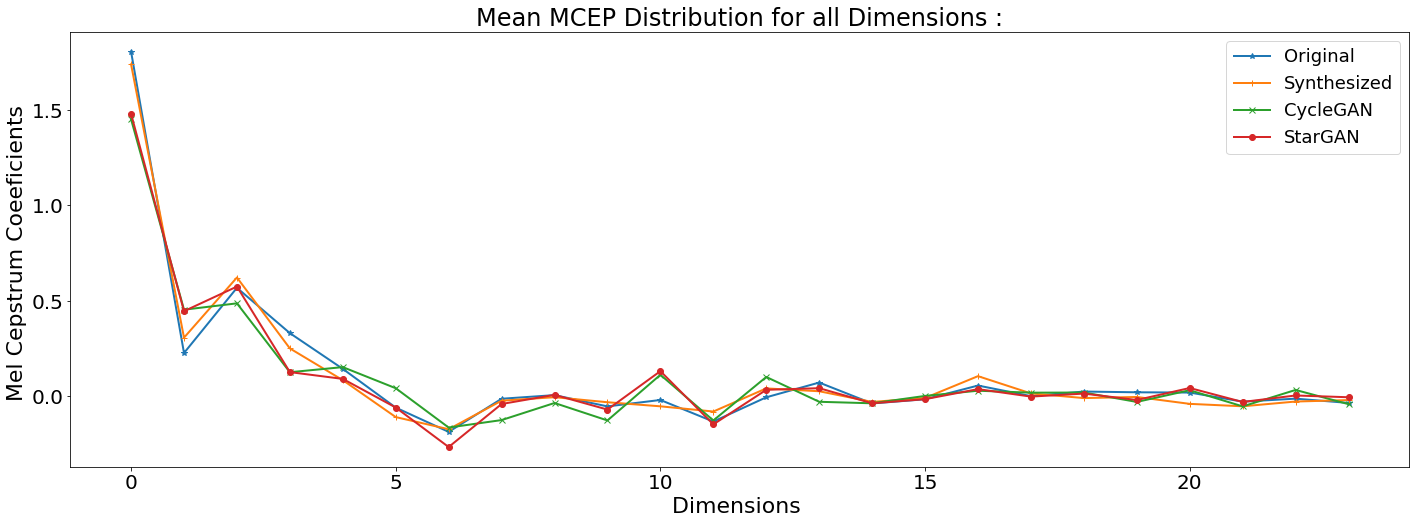

In [20]:
vis(lists,labels,ind)